# Anomaly Detection with NetworkX codes

In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_rows=1000
pd.options.display.max_columns=1000

## Labeled data

In [34]:
data = pd.read_csv("annotated-trace.csv", names=['srcIP', 'dstIP', 'proto', 'srcPort', 'dstPort', 'label'])

In [3]:
data.head()

,srcIP,dstIP,proto,srcPort,dstPort,label
0,214,776,17,21,79,normal
1,933,79,6,21,80,normal
2,139,243,17,53,80,normal
3,920,198,6,80,21,normal
4,100,174,17,20,21,normal


In [32]:
# plot function for graph
def plot_graph(g):
    plt.figure(figsize=(20,12))
    pos = nx.spring_layout(g)
    nx.draw_networkx_nodes(g, pos, node_color="plum", node_size = 500)
    nx.draw_networkx_labels(g, pos)
    nx.draw_networkx_edges(g, pos, edgelist=g.edges, arrows=True)
    plt.axis('off')

    plt.show()

In [43]:
# formatting the data so that the nodes are unique for each column
for k in data.columns:
    data[k] = ["{}:{}".format(k, v) for v in data[k].values]

In [6]:
# The order for the graphlets generation
data[['srcIP', 'proto', 'dstIP', 'srcPort', 'dstPort', 'dstIP']].head()

,srcIP,proto,dstIP,srcPort,dstPort,dstIP
0,srcIP:214,proto:17,dstIP:776,srcPort:21,dstPort:79,dstIP:776
1,srcIP:933,proto:6,dstIP:79,srcPort:21,dstPort:80,dstIP:79
2,srcIP:139,proto:17,dstIP:243,srcPort:53,dstPort:80,dstIP:243
3,srcIP:920,proto:6,dstIP:198,srcPort:80,dstPort:21,dstIP:198
4,srcIP:100,proto:17,dstIP:174,srcPort:20,dstPort:21,dstIP:174


In [30]:
def generate_activity_graphlet(df):
    """
    Given a dataframe representing the data for a graphlet, generate the 
    activity graphlet
    """
    g = nx.DiGraph(directed=True)
    cols = ['srcIP', 'proto', 'dstIP', 'srcPort', 'dstPort', 'dstIP']
    for r in df[cols].values:
        for i in range(0, len(cols)-1):
            g.add_edge(r[i], r[i+1])
            
    return g

def get_neighbouring_node(g, node, orig_node, prof_g, dstNode=None, _type="in", depth=6):
#     print("node", node, orig_node, dstNode, _type)
    """
    Given the graph, find all the adjacent nodes in the path based on outgoing or incoming edges
    """
    if node == orig_node or (orig_node is not None and not orig_node.startswith('dstIP') \
                             and dstNode is not None) or depth == 0:
        return prof_g

    if not orig_node:
        orig_node = node

    nodes = g.in_edges(node) if _type == "in" else g.out_edges(node)
    for n in nodes:
        _next = n[0] if _type == "in" else n[1]
        if _next.startswith('dstIP'):
            dstNode = _next

        prof_g.add_edge(n[0], n[1])
        print("depth", depth)
        get_neighbouring_node(g, _next, orig_node, prof_g, dstNode, _type, depth-1)
    
    return prof_g

def generate_profile_graphlet(df):
    # generate activity graphlet
    g = nx.DiGraph(directed=True)
    cols = ['srcIP', 'proto', 'dstIP', 'srcPort', 'dstPort', 'dstIP']
    for r in df[cols].values:
        for i in range(0, len(cols)-1):
            g.add_edge(r[i], r[i+1])
            
    # get significant nodes
    sig_nodes = []
    indegs = g.in_degree()
    outdegs = g.out_degree()
    for node in g.nodes():
        if indegs[node] > 1 or outdegs[node] > 1:
            sig_nodes.append(node)

    if len(sig_nodes) == 0:
        return None

    prof_g = nx.DiGraph(directed=True)

    # For each significant node, apply the profiling
    # to generate profile graphlet
    for node in sig_nodes:
        n_len = []
        lens = []
        for n in g.neighbors(node):
            num_neighbors = len(list(g.neighbors(n)))
            n_len.append([n, num_neighbors])
            lens.append(num_neighbors)
        lens.sort(reverse=True)
        _max_len = lens[0]

        n_len_cpy = n_len.copy()
        for idx, n in enumerate(n_len_cpy):
            if n[1] != _max_len:
                n_len.remove(n)

        prof_g = get_neighbouring_node(g, node, None, prof_g, None, "in")
        for n in n_len:
            prof_g = get_neighbouring_node(g, n[0], None, prof_g, None, "out")
        
    return prof_g

def generate_graphlets(data):
    subdf = []

    if 'label' in data.columns:
        # break down the large df into smaller df for each graphlet
        # based on the srcIP and label
        for ip in np.unique(data.srcIP.values):
            for lbl in np.unique(data.label.values):
                d = data[(data.srcIP == ip) & (data.label == lbl)]
                if d.shape[0] > 0:
                    subdf.append(d)

        graphlets = []
        for df in subdf:
            profile_graphlet = generate_profile_graphlet(df)
            label = 1 if df['label'].values[0] == 'label:anomaly' else 0
            if profile_graphlet is not None:
                graphlets.append([profile_graphlet, label])
    else:
        for ip in np.unique(data.srcIP.values):
            d = data[(data.srcIP == ip)]
            if d.shape[0] > 0:
                subdf.append(d)

        graphlets = []
        for df in subdf:
            profile_graphlet = generate_profile_graphlet(df)
            label = 0
            if profile_graphlet is not None:
                graphlets.append([profile_graphlet, label])

    return graphlets

In [42]:
data.shape

(10070, 6)

In [ ]:
data[data.label == 'label:anomaly'].sort_values("srcIP")

In [44]:
negative = data[data.label == 'label:anomaly']

In [45]:
positive = data[data.label == 'label:normal'].sample(negative.shape[0])

In [46]:
df = pd.concat([negative, positive], axis=0)

In [47]:
df.shape

(140, 6)

In [48]:
graphlets = generate_graphlets(df)

In [49]:
len(graphlets)

125

In [50]:
df.head()

,srcIP,dstIP,proto,srcPort,dstPort,label
14,srcIP:812,dstIP:499,proto:6,srcPort:53,dstPort:14,label:anomaly
195,srcIP:796,dstIP:499,proto:6,srcPort:68,dstPort:22,label:anomaly
249,srcIP:325,dstIP:661,proto:17,srcPort:22,dstPort:20,label:anomaly
385,srcIP:1709,dstIP:791,proto:6,srcPort:21,dstPort:80,label:anomaly
666,srcIP:119,dstIP:661,proto:17,srcPort:22,dstPort:20,label:anomaly


In [37]:
keys = np.unique(data[['srcIP', 'dstIP', 'proto', 'srcPort', 'dstPort']].values.flatten())

def generate_adjacency_matrix(g, keys):
    """
    Generate the adjacency matrix for a graph G with all keys
    """
    all_paths = [p for x in g.nodes() for target in g.nodes() \
                 for p in nx.all_simple_paths(g, x, target, 1)]

    # Generate DF for all the paths to generate the adjacency matrix
    df = pd.DataFrame.from_records(all_paths, columns=['node1', 'node2'])
    df['value'] = 1
    df = df.groupby(['node1', 'node2']).count().reset_index()

    # Existence will be counted as 1 instead of multiple counts
    df['value'] = df['value'].apply(lambda x: 1 if x > 0 else 0)
    
    # Generate the matrix with df.pivot()
    mat = df.pivot(index='node1', columns='node2', values='value'
                        ).reindex(columns=keys, index=keys).fillna(0)
    
    return mat

In [38]:
count = 0
def random_walk(g, L, keys):
    global count
    print(count)
    a0 = np.identity(len(keys))
    a1 = generate_adjacency_matrix(g, keys)
    
    rw_mat = a0 + a1 
    for i in range(1, L):
        mat = a1
        for j in range(i):
            mat = np.dot(mat, a1)
        rw_mat += mat
    count+=1
    return rw_mat.values.flatten().tolist()

In [ ]:
count = 0
features = [random_walk(g, 4, keys) for g, l in graphlets]

In [56]:
y = [g[1] for g in graphlets]

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.20, random_state=42)

In [58]:
from sklearn import svm

clf = svm.SVC(kernel='linear', verbose=True)

In [59]:
%timeit clf.fit(X_train, y_train) 

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]3min 55s ± 12.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [60]:
from joblib import dump, load

dump(clf, 'svmlinear2.joblib') 

['svmlinear2.joblib']

In [61]:
clf_rbf = svm.SVC() # default  rbf

In [62]:
%timeit clf_rbf.fit(X_train, y_train) 

/Users/sherly/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/sherly/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/sherly/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/sherly/anaconda/lib/python3.6/site-packages/skle

4min 29s ± 18.9 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [63]:
dump(clf_rbf, 'svmrbf2.joblib') 

['svmrbf2.joblib']

In [89]:
from sklearn.metrics import classification_report, confusion_matrix

In [71]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.93      0.97        15

   micro avg       0.96      0.96      0.96        25
   macro avg       0.95      0.97      0.96        25
weighted avg       0.96      0.96      0.96        25



In [90]:
confusion_matrix(y_test, clf.predict(X_test))

array([[10,  0],
       [ 1, 14]])

In [72]:
print(classification_report(y_test, clf_rbf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.40      1.00      0.57        10
           1       0.00      0.00      0.00        15

   micro avg       0.40      0.40      0.40        25
   macro avg       0.20      0.50      0.29        25
weighted avg       0.16      0.40      0.23        25



/Users/sherly/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [92]:
confusion_matrix(y_test, clf_rbf.predict(X_test))

array([[10,  0],
       [15,  0]])

## Unlabeled data 

In [7]:
unlabeled_data = pd.read_csv("not-annotated-trace.csv", names=['srcIP', 'dstIP', 'proto', 'srcPort', 'dstPort'])

In [8]:
unlabeled_data.shape

(10070, 5)

In [9]:
for k in unlabeled_data.columns:
    unlabeled_data[k] = ["{}:{}".format(k, v) for v in unlabeled_data[k].values]

In [10]:
ips = np.random.choice(unlabeled_data.srcIP.values, 5)
subset_data = unlabeled_data[unlabeled_data.srcIP.isin(ips)]

In [11]:
unlabeled_data.head()

,srcIP,dstIP,proto,srcPort,dstPort
0,srcIP:881,dstIP:296,proto:6,srcPort:80,dstPort:25
1,srcIP:799,dstIP:20,proto:6,srcPort:80,dstPort:22
2,srcIP:897,dstIP:790,proto:17,srcPort:80,dstPort:21
3,srcIP:41,dstIP:994,proto:17,srcPort:23,dstPort:53
4,srcIP:361,dstIP:535,proto:6,srcPort:21,dstPort:22


In [24]:
ips

array(['srcIP:349', 'srcIP:335', 'srcIP:522', 'srcIP:195', 'srcIP:924'],
      dtype=object)

In [ ]:
g = generate_profile_graphlet(subset_data[subset_data.srcIP == 'srcIP:349'])

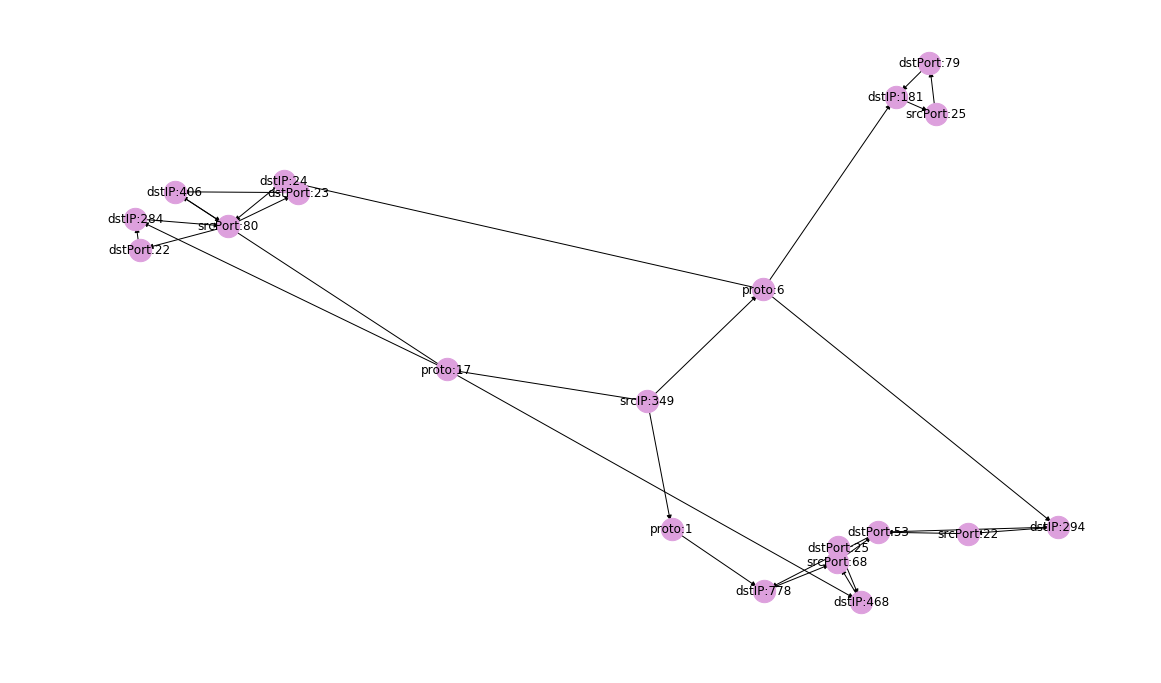

In [33]:
plot_graph(g)